In [1]:
import cv2
import numpy as np

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torch_data
from torchvision import models as torch_models

%matplotlib inline
import matplotlib.pyplot as plt

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dset = []
for file in Path('EyesDataset').iterdir():
    img = cv2.imread(str(file))
    dset.append(img)
    
dset = np.array(dset, dtype='f4') / 255
dset_flat = dset.reshape(len(dset), -1)

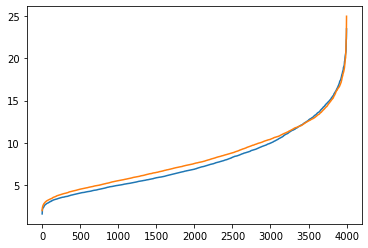

In [3]:
kmeans = KMeans(n_clusters=2, random_state=seed).fit(dset_flat)
dist = kmeans.transform(dset_flat)

plt.plot(np.sort(dist[:, 0]));
plt.plot(np.sort(dist[:, 1]));

In [4]:
# ids = np.arange(dset_flat.shape[1])
# plt.scatter(ids, kmeans.cluster_centers_[0]);
# plt.scatter(ids, kmeans.cluster_centers_[1]);

In [5]:
X = dset.transpose(0, 3, 1, 2)
y = kmeans.labels_
y = y.astype('f4')
y[np.where(y==0)[0]] = .1
y[np.where(y==1)[0]] = .9

In [51]:
# y_soft = y.copy().astype('f4')
# y_soft[np.where(y==0)] = .1
# y_soft[np.where(y==1)] = .9

In [6]:
mask1 = y.astype('bool')
plt.imshow(dset[~mask1][32]);

IndexError: index 32 is out of bounds for axis 0 with size 0

In [7]:
X_train, X_test, y_train, y_test = map(torch.Tensor,
    train_test_split(X, y, test_size=.2, random_state=seed))

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(
                3, 32, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                32, 16, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                16, 8, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),

            nn.Conv2d(
                8, 4, kernel_size=3,
                stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(4, 1, kernel_size=2)
        )
        
    def forward(self, X):
        return self.main(X).flatten()
    
    def predict(self, X):
        return self.forward(X).sigmoid()

In [9]:
class BatchLoader:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.bs = batch_size
        self.gen = None

    def _gen(self):
        ids = np.arange(len(self.y))
        np.random.shuffle(ids)

        for i in range(0, len(self.y), self.bs):
            yield self.X[i:i+self.bs], self.y[i:i+self.bs]

    def __call__(self):
        self.gen = self._gen()

In [10]:
def ROC_EER(y_true, y_pred, return_roc=False):
    if isinstance(y_pred, torch.Tensor):
        y_true = y_true.cpu()
        y_pred = y_pred.detach().cpu()
        
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    eer = fpr[np.nanargmin(np.absolute(1 - tpr - fpr))]
    if return_roc: return eer, fpr, tpr
    return eer

In [11]:
def train(
    net, criterion, optimizer, train_bl, val_bl,
    scheduler=None, epochs=10, verbose=True, validation='EER'):
    if verbose: print('Epoch\t\tTrain\t\tValidation')
    if validation == 'EER': print('\t\t\t\tBCE\tEER')
    print()

    for epoch in range(1, epochs+1):
        train_loss = val_loss = 0
        net.train()

        train_bl()
        val_bl()

        for X,y in train_bl.gen:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device)
            
            loss = criterion(net(X), y)
            loss.backward()
            train_loss += loss.item() * len(y)/len(train_bl.y)

            optimizer.step()

        net.eval()
        for X,y in val_bl.gen:
            X, y = X.to(device), y.to(device)

            y_pred = net(X)
            loss = criterion(y_pred, y)

            val_loss += loss.item() * len(y)/len(val_bl.y)

        if scheduler is not None: scheduler.step()

        freq = max(epochs//20, 1)
        if verbose and epoch % freq == 0:
            logline = f'{epoch}/{epochs}\t\t{train_loss:.4}\t\t{val_loss:.4f}'
            if validation == 'EER': logline += f'\t{ROC_EER(val_bl.y, net(val_bl.X)):.4}'
            print(logline)

In [12]:
net = SimpleNet().to(device)
opt = optim.Adam(net.parameters(), lr=3e-3)

criterion = nn.BCEWithLogitsLoss()

train_bl = BatchLoader(X_train, y_train, 100)
val_bl = BatchLoader(X_test, y_test, 100)

In [14]:
train(net, criterion, opt, train_bl, val_bl, epochs=20, validation=None)

Epoch		Train		Validation

1/20		0.3875		0.3723
2/20		0.3812		0.3686
3/20		0.3783		0.3675
4/20		0.3762		0.3664
5/20		0.3741		0.3661
6/20		0.3726		0.3663
7/20		0.3712		0.3660
8/20		0.3697		0.3667
9/20		0.3684		0.3674
10/20		0.367		0.3694
11/20		0.3658		0.3690
12/20		0.3643		0.3676
13/20		0.3633		0.3872
14/20		0.3617		0.3727
15/20		0.3603		0.3848
16/20		0.3591		0.3820
17/20		0.358		0.3734
18/20		0.3567		0.3879
19/20		0.3558		0.3800
20/20		0.3549		0.4199


In [18]:
y_pred = net.predict(X_test)
eer, fpr, tpr = ROC_EER(y_test, y_pred, return_roc=True)

EER = 0.03826530612244898


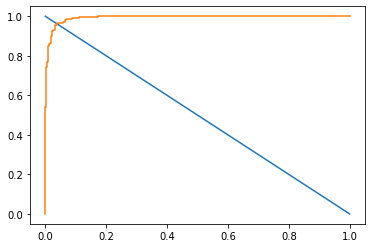

In [19]:
x = np.linspace(0, 1, num=len(fpr))
print('EER =', eer)

plt.plot(x, 1-x);
plt.plot(fpr, tpr);